In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error
from sklearn import tree
import graphviz 
import os
import pymysql
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
username = 'username'
password = 'password'
host_port = 'host_ip:host_port' 
database = 'database_name'

engine = create_engine("mysql+pymysql://{}:{}@{}/{}".format(username, password, host_port, database))
con = engine.connect()

In [3]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mad(y_true, y_pred):
    return sum(np.abs((y_true - y_pred) / len(y_true)))

In [35]:
market_list=['台北一', '台北二', '三重區', '台中市']
result = []
adj_result = []
test = []
fruit = "guava"
for adjustment in range(2):
    for market in market_list:
        data = pd.read_sql(f"{fruit}_{market}", engine)
        # 與時間序列比較，因此數據採用至2021/6/15
        data2 = data[:3819:].copy()
        col_price_guava=['guava_平均價', 'emperorguava_平均價', 'banana_平均價', 'guava_前日平均價', 'guava_5日平均價']
        data2[col_price_guava] = data2[col_price_guava]*10
        data2[col_price_guava] = data2[col_price_guava].astype(int)
        train_data=data2[0:-32:1]
        test_data=data2[-1:-32:-1]
        if adjustment == 0:
            # feature未調整
            X_train = train_data[['guava_交易量', 'emperorguava_平均價', 'banana_平均價', 'guava_前日平均價', 'guava_5日平均價']].to_numpy()
            X_test = test_data[['guava_交易量', 'emperorguava_平均價', 'banana_平均價', 'guava_前日平均價', 'guava_5日平均價']][::-1].to_numpy()
        elif adjustment == 1:
            # feature調整後
            # 拆分年月日、四捨五入至個位數
            data2['year'] = data2['日期'].apply(lambda x: x.year)
            data2['month'] = data2['日期'].apply(lambda x: x.month)
            data2['day'] = data2['日期'].apply(lambda x: x.day)
            data2['guava_平均價_round'] = data2['guava_平均價'].round(0).apply(lambda x: int(x))
            data2['emperorguava_平均價_round'] = data2['emperorguava_平均價'].round(0).apply(lambda x: int(x))
            data2['banana_平均價_round'] = data2['banana_平均價'].round(0).apply(lambda x: int(x))
            data2['guava_前日平均價_round'] = data2['guava_前日平均價'].round(0).apply(lambda x: int(x))
            data2['guava_5日平均價_round'] = data2['guava_5日平均價'].round(0).apply(lambda x: int(x))
            train_data=data2[0:-32:1]
            test_data=data2[-1:-32:-1]
            X_train = train_data[['guava_交易量', 'emperorguava_平均價', 'banana_平均價',
                                'guava_前日平均價', 'guava_5日平均價','year', 'month',
                                'day', 'emperorguava_平均價_round', 'banana_平均價_round',
                                'guava_前日平均價_round', 'guava_5日平均價_round']].to_numpy()
            X_test = test_data[['guava_交易量', 'emperorguava_平均價', 'banana_平均價',
                                'guava_前日平均價', 'guava_5日平均價','year', 'month',
                                'day', 'emperorguava_平均價_round', 'banana_平均價_round',
                                'guava_前日平均價_round', 'guava_5日平均價_round']][::-1].to_numpy()
        y_train = train_data['guava_平均價']
        y_test = test_data['guava_平均價'][::-1]
        model = RandomForestRegressor(max_depth=None, n_estimators=50, random_state=100,
                                  bootstrap=True, oob_score=False, criterion = 'mae')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # 儲存結果
        if adjustment==0:
            test.append(y_test)
            result.append(y_pred)
        elif adjustment==1:
            adj_result.append(y_pred)
        
        #模型評估
        mape_result=mape(y_test/10, y_pred/10)
        mad_result=mad(y_test/10, y_pred/10)
        rmse_result=mean_squared_error(y_test/10, y_pred/10)
        if adjustment==0 and market == market_list[0]:
            print("original model")
            print("===================================")
        elif adjustment!=0 and market == market_list[0]:
            print("adjustment model")
            print("===================================")
        print(f'{market} rmse_result={rmse_result}')
        print(f'{market} mape_result={mape_result}')
        print(f'{market} mad_result={mad_result}')
        print("-----------------------------------")

original model
台北一 rmse_result=21.03898258064516
台北一 mape_result=10.651464262640907
台北一 mad_result=3.754774193548387
-----------------------------------
台北二 rmse_result=12.449870193548383
台北二 mape_result=7.579648753514916
台北二 mad_result=2.784903225806451
-----------------------------------
三重區 rmse_result=5.531494709677419
三重區 mape_result=5.5730341611916066
三重區 mad_result=1.8381935483870966
-----------------------------------
台中市 rmse_result=9.662638064516125
台中市 mape_result=6.7042106505467824
台中市 mad_result=2.1994193548387084
-----------------------------------
adjustment model
台北一 rmse_result=21.37945316129033
台北一 mape_result=10.410841112048724
台北一 mad_result=3.697677419354839
-----------------------------------
台北二 rmse_result=11.939004548387102
台北二 mape_result=7.56740445405187
台北二 mad_result=2.8140967741935485
-----------------------------------
三重區 rmse_result=5.371034645161294
三重區 mape_result=5.303098283897901
三重區 mad_result=1.760064516129033
-----------------------------------
台

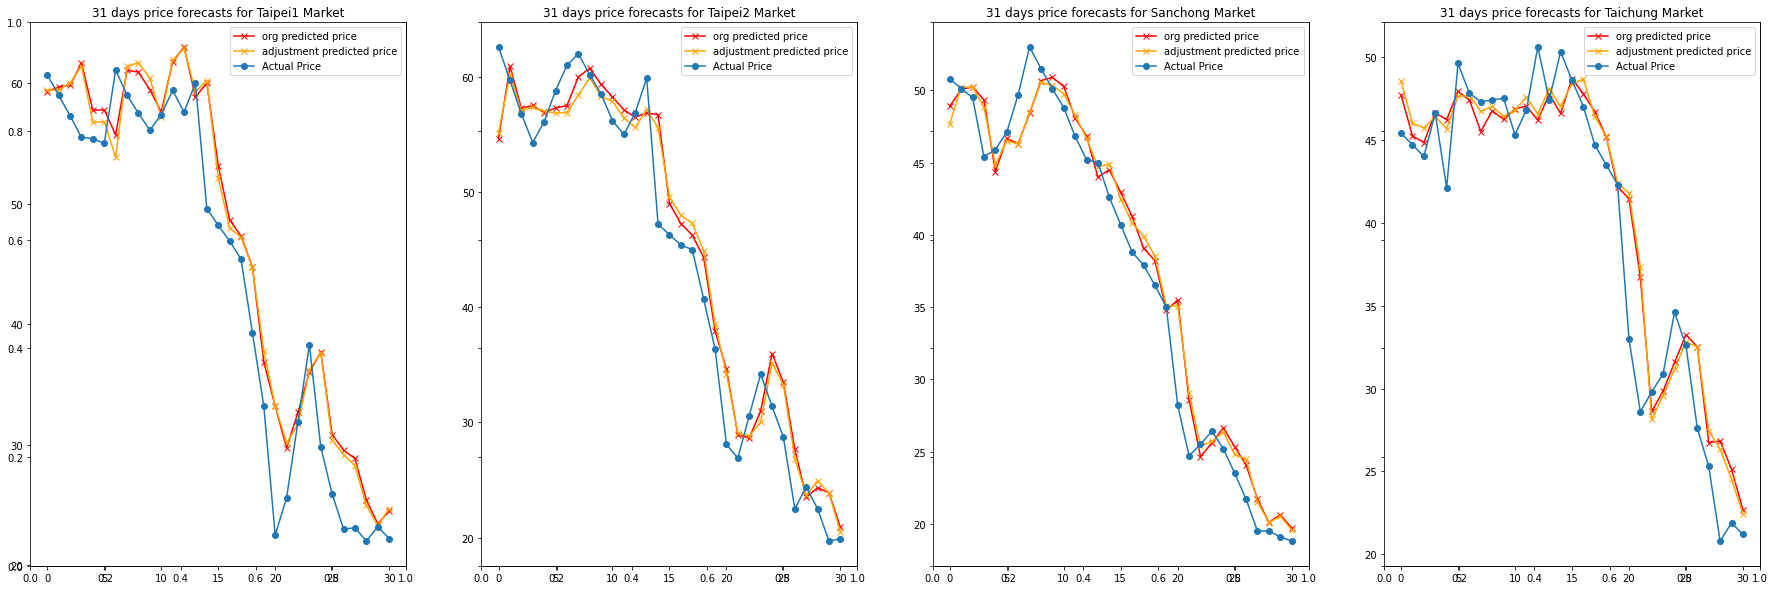

In [31]:
# 畫出價格折線圖
fig, axes = plt.subplots(1, 4, figsize=(31,10), sharey=True) #, squeeze=True)
markets = ["Taipei1", "Taipei2", "Sanchong", "Taichung"]
n=31
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(np.arange(n), result[i]/10, label="origin predicted price", color="red", marker="x")
    ax.plot(np.arange(n), adj_result[i]/10, label="adjustment predicted price", color="orange", marker="x")
    ax.plot(np.arange(n), test[i]/10, label="Actual Price", marker="o")
    ax.set_title(f"31 days price forecasts for {markets[i%4]} Market")
    ax.legend(loc="upper right")